# Predictive Maintenance Dataset
Dataset by kaggle (https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?resource=download)<br>
Notebook by Tobias Kessel (https://www.linkedin.com/in/tobias-kessel-045806b5/)

__The dataset consists of 10 000 data points stored as rows with 14 features in columns__
***
* UID: unique identifier ranging from 1 to 10000
* productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
*air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
*process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air *temperature plus 10 K.
*rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
*torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
*tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
***
__Important : There are two Targets__

* Target : Failure or Not
* Failure Type : Type of Failure
***

# __Step 1:__ 
Importing libraries and CSV

In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump, load
import timeit

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Activation, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, Sequential

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [3]:
df=pd.read_csv('predictive_maintenance.csv',index_col='UDI')

# __Step 2:__ 
Data Assessment

In [4]:
df.head(10)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 781.2+ KB


In [6]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


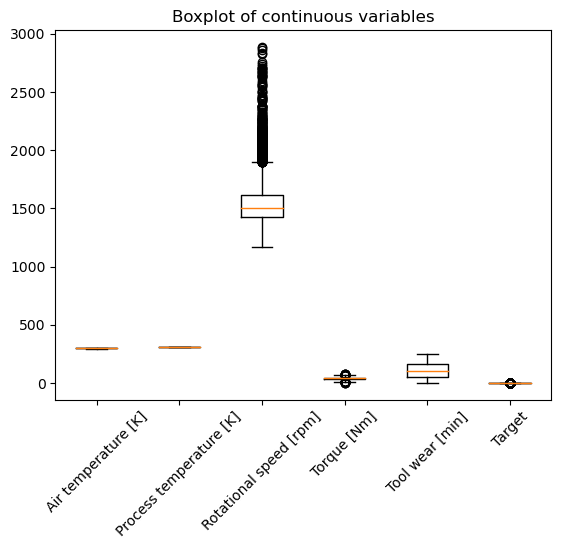

In [7]:
plt.boxplot(df.select_dtypes(include=['float64','int64']),labels=df.select_dtypes(include=['float64','int64']).columns)
plt.title('Boxplot of continuous variables')
plt.xticks(rotation=45);

In [8]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

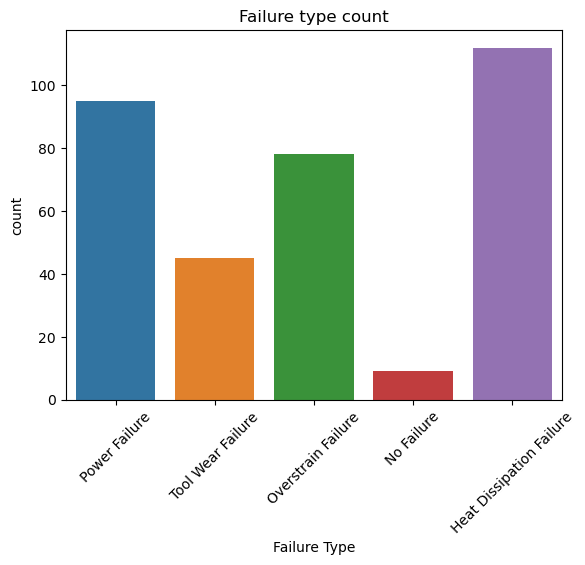

In [9]:
sns.countplot(x='Failure Type',data=df[df['Target']==1])
plt.title('Failure type count')
plt.xticks(rotation=45);

In [10]:
df['Failure Type'].value_counts(normalize=True)

No Failure                  0.9652
Heat Dissipation Failure    0.0112
Power Failure               0.0095
Overstrain Failure          0.0078
Tool Wear Failure           0.0045
Random Failures             0.0018
Name: Failure Type, dtype: float64

In [11]:
print('Amount of failures: {}'.format(df['Target'].sum()))

Amount of failures: 339


In [12]:
print('Failed to non failed ratio: {}%'.format(100*df['Target'].sum()/df.shape[0]))

Failed to non failed ratio: 3.39%


In [13]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

<AxesSubplot:xlabel='UDI'>

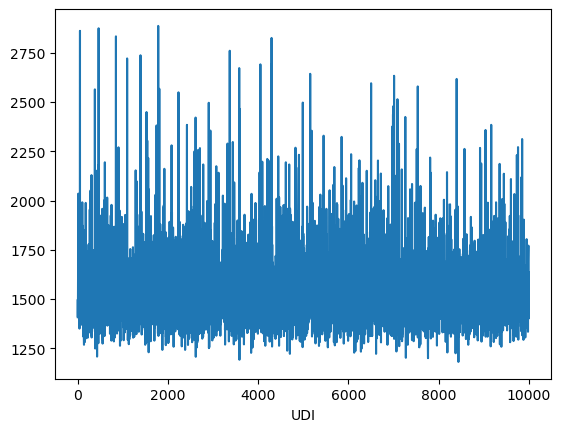

In [14]:
df[df['Type']=='L']['Rotational speed [rpm]'].plot()

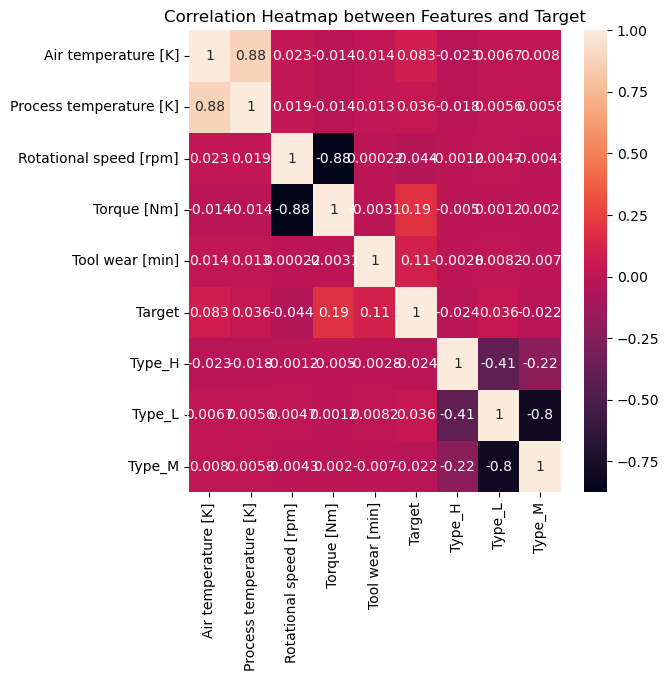

In [15]:
plt.figure(figsize=(6,6))
sns.heatmap(df.join(pd.get_dummies(df['Type'],prefix='Type')).corr(),annot=True)
plt.title('Correlation Heatmap between Features and Target');

# __Step 3:__ 
Features and Target Preparation

In [16]:
# Splitting of Dataframe into X and y1,y2
X=df.drop(['Target','Failure Type'],axis=1)
y1=df['Target']

In [17]:
# One-Hot encoding of feature 'Type' + StandardScaling of all features
X=X.join(pd.get_dummies(X['Type'],prefix='Type'))
X.drop(['Type','Product ID'],axis=1,inplace=True)

#Scaling
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [18]:
display(X_scaled)

array([[-0.95238944, -0.94735989,  0.06818514, ..., -0.33388861,
        -1.22474487,  1.52861702],
       [-0.90239341, -0.879959  , -0.72947151, ..., -0.33388861,
         0.81649658, -0.65418609],
       [-0.95238944, -1.01476077, -0.22744984, ..., -0.33388861,
         0.81649658, -0.65418609],
       ...,
       [-0.50242514, -0.94735989,  0.59251888, ..., -0.33388861,
        -1.22474487,  1.52861702],
       [-0.50242514, -0.879959  , -0.72947151, ...,  2.99501081,
        -1.22474487, -0.65418609],
       [-0.50242514, -0.879959  , -0.2162938 , ..., -0.33388861,
        -1.22474487,  1.52861702]])

In [19]:
display(y1)

UDI
1        0
2        0
3        0
4        0
5        0
        ..
9996     0
9997     0
9998     0
9999     0
10000    0
Name: Target, Length: 10000, dtype: int64

In [20]:
# One-Hot encoding of target 'Failure Type'
y2=pd.get_dummies(df['Failure Type'],prefix='F-Type')
#y2.drop('Failure Type',axis=1,inplace=True)
display(y2)

,F-Type_Heat Dissipation Failure,F-Type_No Failure,F-Type_Overstrain Failure,F-Type_Power Failure,F-Type_Random Failures,F-Type_Tool Wear Failure
UDI,,,,,,
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0
...,...,...,...,...,...,...
9996,0,1,0,0,0,0
9997,0,1,0,0,0,0
9998,0,1,0,0,0,0


# __Step 4:__ 
Setting up and validating several classifiers

In [21]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.2,random_state=123)

# Stratified KFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [43]:
# Classifiers with Grid Search

# Results
results=pd.DataFrame()

# Timestamp
timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')

# Algo Setup
knn=KNeighborsClassifier(n_neighbors=10, metric='manhattan', weights='uniform')

cv_result=cross_validate(knn, X, y1, scoring='f1', cv=cv, return_train_score=True, n_jobs=-1)

print('Train Accuracy: %.3f | Score: %.4f' % (cv_result['train_score'].mean(),cv_result['train_score'].std()))
print('  Val Accuracy: %.3f | Score: %.4f' % (cv_result['test_score'].mean(),cv_result['test_score'].std()))

Train Accuracy: 0.321 | Score: 0.0202
  Val Accuracy: 0.293 | Score: 0.0564


In [44]:
y_pred=cross_val_predict(knn, X, y1, cv=5, n_jobs=-1)
display(pd.crosstab(y1,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y1,y_pred))

Prediction,0,1
Reality,,
0,9652,9
1,283,56


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9661
           1       0.86      0.17      0.28       339

    accuracy                           0.97     10000
   macro avg       0.92      0.58      0.63     10000
weighted avg       0.97      0.97      0.96     10000



In [45]:
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1923,1
1,63,13


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1924
           1       0.93      0.17      0.29        76

    accuracy                           0.97      2000
   macro avg       0.95      0.59      0.64      2000
weighted avg       0.97      0.97      0.96      2000



Recall for failure (1) is very bad, probably due to under-representation of failure cases

In [46]:
from imblearn.over_sampling import RandomOverSampler
ro=RandomOverSampler()
X_train_ro,y_train_ro=ro.fit_resample(X_train,y_train)

In [47]:
knn.fit(X_train_ro,y_train_ro)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [48]:
y_pred=knn.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1769,155
1,31,45


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1924
           1       0.23      0.59      0.33        76

    accuracy                           0.91      2000
   macro avg       0.60      0.76      0.64      2000
weighted avg       0.95      0.91      0.93      2000



In [71]:
knn=KNeighborsClassifier()
n_neighbors=[1,2,3,4,5,7,9,11,13,15,17,19,21]
metric=['euclidean','manhattan','minkowski']
weights=['uniform','distance']
parameters=dict(n_neighbors=n_neighbors,metric=metric,weights=weights)

timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
grid=GridSearchCV(estimator=knn,param_grid=parameters,n_jobs=-1,cv=5,scoring='f1',error_score=0,verbose=3)
grid.fit(X_train_ro,y_train_ro)
timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
print(grid.best_params_)
print(grid.best_score_)

02.03.2023 10:54:25
Fitting 5 folds for each of 78 candidates, totalling 390 fits
02.03.2023 10:54:27
{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.9882511083853762


In [72]:
y_pred=grid.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1881,43
1,55,21


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1924
           1       0.33      0.28      0.30        76

    accuracy                           0.95      2000
   macro avg       0.65      0.63      0.64      2000
weighted avg       0.95      0.95      0.95      2000



In [74]:
rfc=RandomForestClassifier()
n_estimators=[10,100,500,1000]
max_features=['sqrt','log2',1,5,10,20]
parameters=dict(n_estimators=n_estimators,max_features=max_features)

timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
grid=GridSearchCV(estimator=rfc,param_grid=parameters,n_jobs=-1,cv=5,scoring='f1',error_score=0,verbose=3)
grid.fit(X_train_ro,y_train_ro)
timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
print(grid.best_params_)
print(grid.best_score_)

02.03.2023 10:54:39
Fitting 5 folds for each of 24 candidates, totalling 120 fits
02.03.2023 10:55:00
{'max_features': 'log2', 'n_estimators': 10}
0.9976795798277234


C:\Users\tkessel\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tkessel\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tkessel\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\tkessel\Anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\tkessel\Anaconda3\lib\site-pa

In [75]:
y_pred=grid.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1917,7
1,38,38


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1924
           1       0.84      0.50      0.63        76

    accuracy                           0.98      2000
   macro avg       0.91      0.75      0.81      2000
weighted avg       0.98      0.98      0.97      2000



The RFC-Algorithm detects 50% of the impending failures

In [76]:
model=load('./Joblibs/RFC_Grid.joblib')

# __Step 5:__ 
Setting up and validating Keras Classifier

In [90]:
#X_train_ro.shape
model=Sequential()
model.add(Dense(units=128,input_shape=(8,1)))